#### <u>NoGAN Synthesizer</u>

Generate Synthetic Data using NoGAN method and compare with CTGAN model

##### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import genai_evaluation as ge
from genai_evaluation import multivariate_ecdf, ks_statistic
import nogan_synthesizer as ns
from nogan_synthesizer import NoGANSynth
from nogan_synthesizer.preprocessing import wrap_category_columns, unwrap_category_columns

from modules import utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


ModuleNotFoundError: No module named 'plotly'

In [ ]:
print(f"Pandas Version: {pd.__version__}")
print(f"NUmpy Version: {np.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"GenAI Version: {ge.__version__}")
print(f"NoGAN Synthesizer Version: {ns.__version__}")

Pandas Version: 2.0.3
NUmpy Version: 1.26.0
Seaborn Version: 0.13.0
Matplotlib Version: 3.8.0
GenAI Version: 0.1.5
NoGAN Synthesizer Version: 0.1.3


##### Default Plot Settings

In [ ]:
# Default plot settings
plt.rcParams["figure.dpi"] = 300
sns.set()


In [ ]:
pd.core.common.random_state(None)
seed = 1003

##### Retrieve Data
Ref:

https://archive-beta.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [ ]:
data = utils.get_cleaned_students_data()
print(f"Data Shape: {data.shape}")

Data Shape: (4424, 37)


##### Select relevant columns and split data into training & validation set using stratified sampling

In [ ]:
data = data.drop(data[data["curricular_units_2nd_sem_grade"] == 0].index)

features = [
  'curricular_units_2nd_sem_approved',
  'curricular_units_2nd_sem_grade',
  'curricular_units_1st_sem_approved',
  'curricular_units_1st_sem_grade',
  'admission_grade',
  'tuition_fees_up_to_date',
  'curricular_units_2nd_sem_evaluations',
  'age_at_enrollment',
  'previous_qualification_grade',
  'curricular_units_1st_sem_evaluations',
  'course',
  'fathers_occupation',
  'mothers_occupation',
  'unemployment_rate',
  'gdp',
  'application_mode',
  'fathers_qualification',
  'curricular_units_2nd_sem_enrolled',
  'mothers_qualification',
  'inflation_rate',
  'target']

target_column = 'target'

cat_cols = ['course', 'fathers_occupation', 'mothers_occupation', 
            'unemployment_rate', 'gdp', 'inflation_rate',
            'application_mode', 'fathers_qualification',
            'mothers_qualification', 'tuition_fees_up_to_date', 'target'
            ]

num_cols = [f for f in features if f not in cat_cols]

data = data[features]
print(f"Data Shape: {data.shape}")

Data Shape: (3554, 21)


In [ ]:
# Stratified Test Split to make sure the target columns are distributed well in the train & test split
training_data, validation_data = \
          utils.stratified_train_test_split(data,
                                            target_column = target_column,
                                            train_size=0.5,
                                            random_state = seed
                                            )

print(f"Data Shape: {data.shape}\nTraining Shape: {training_data.shape}\nValidation Shape: {validation_data.shape}")          

Data Shape: (3554, 21)
Training Shape: (1777, 21)
Validation Shape: (1777, 21)


##### Plot the proportion of rows per target in Original, Training & Validation to ensure that the stratified sampling works

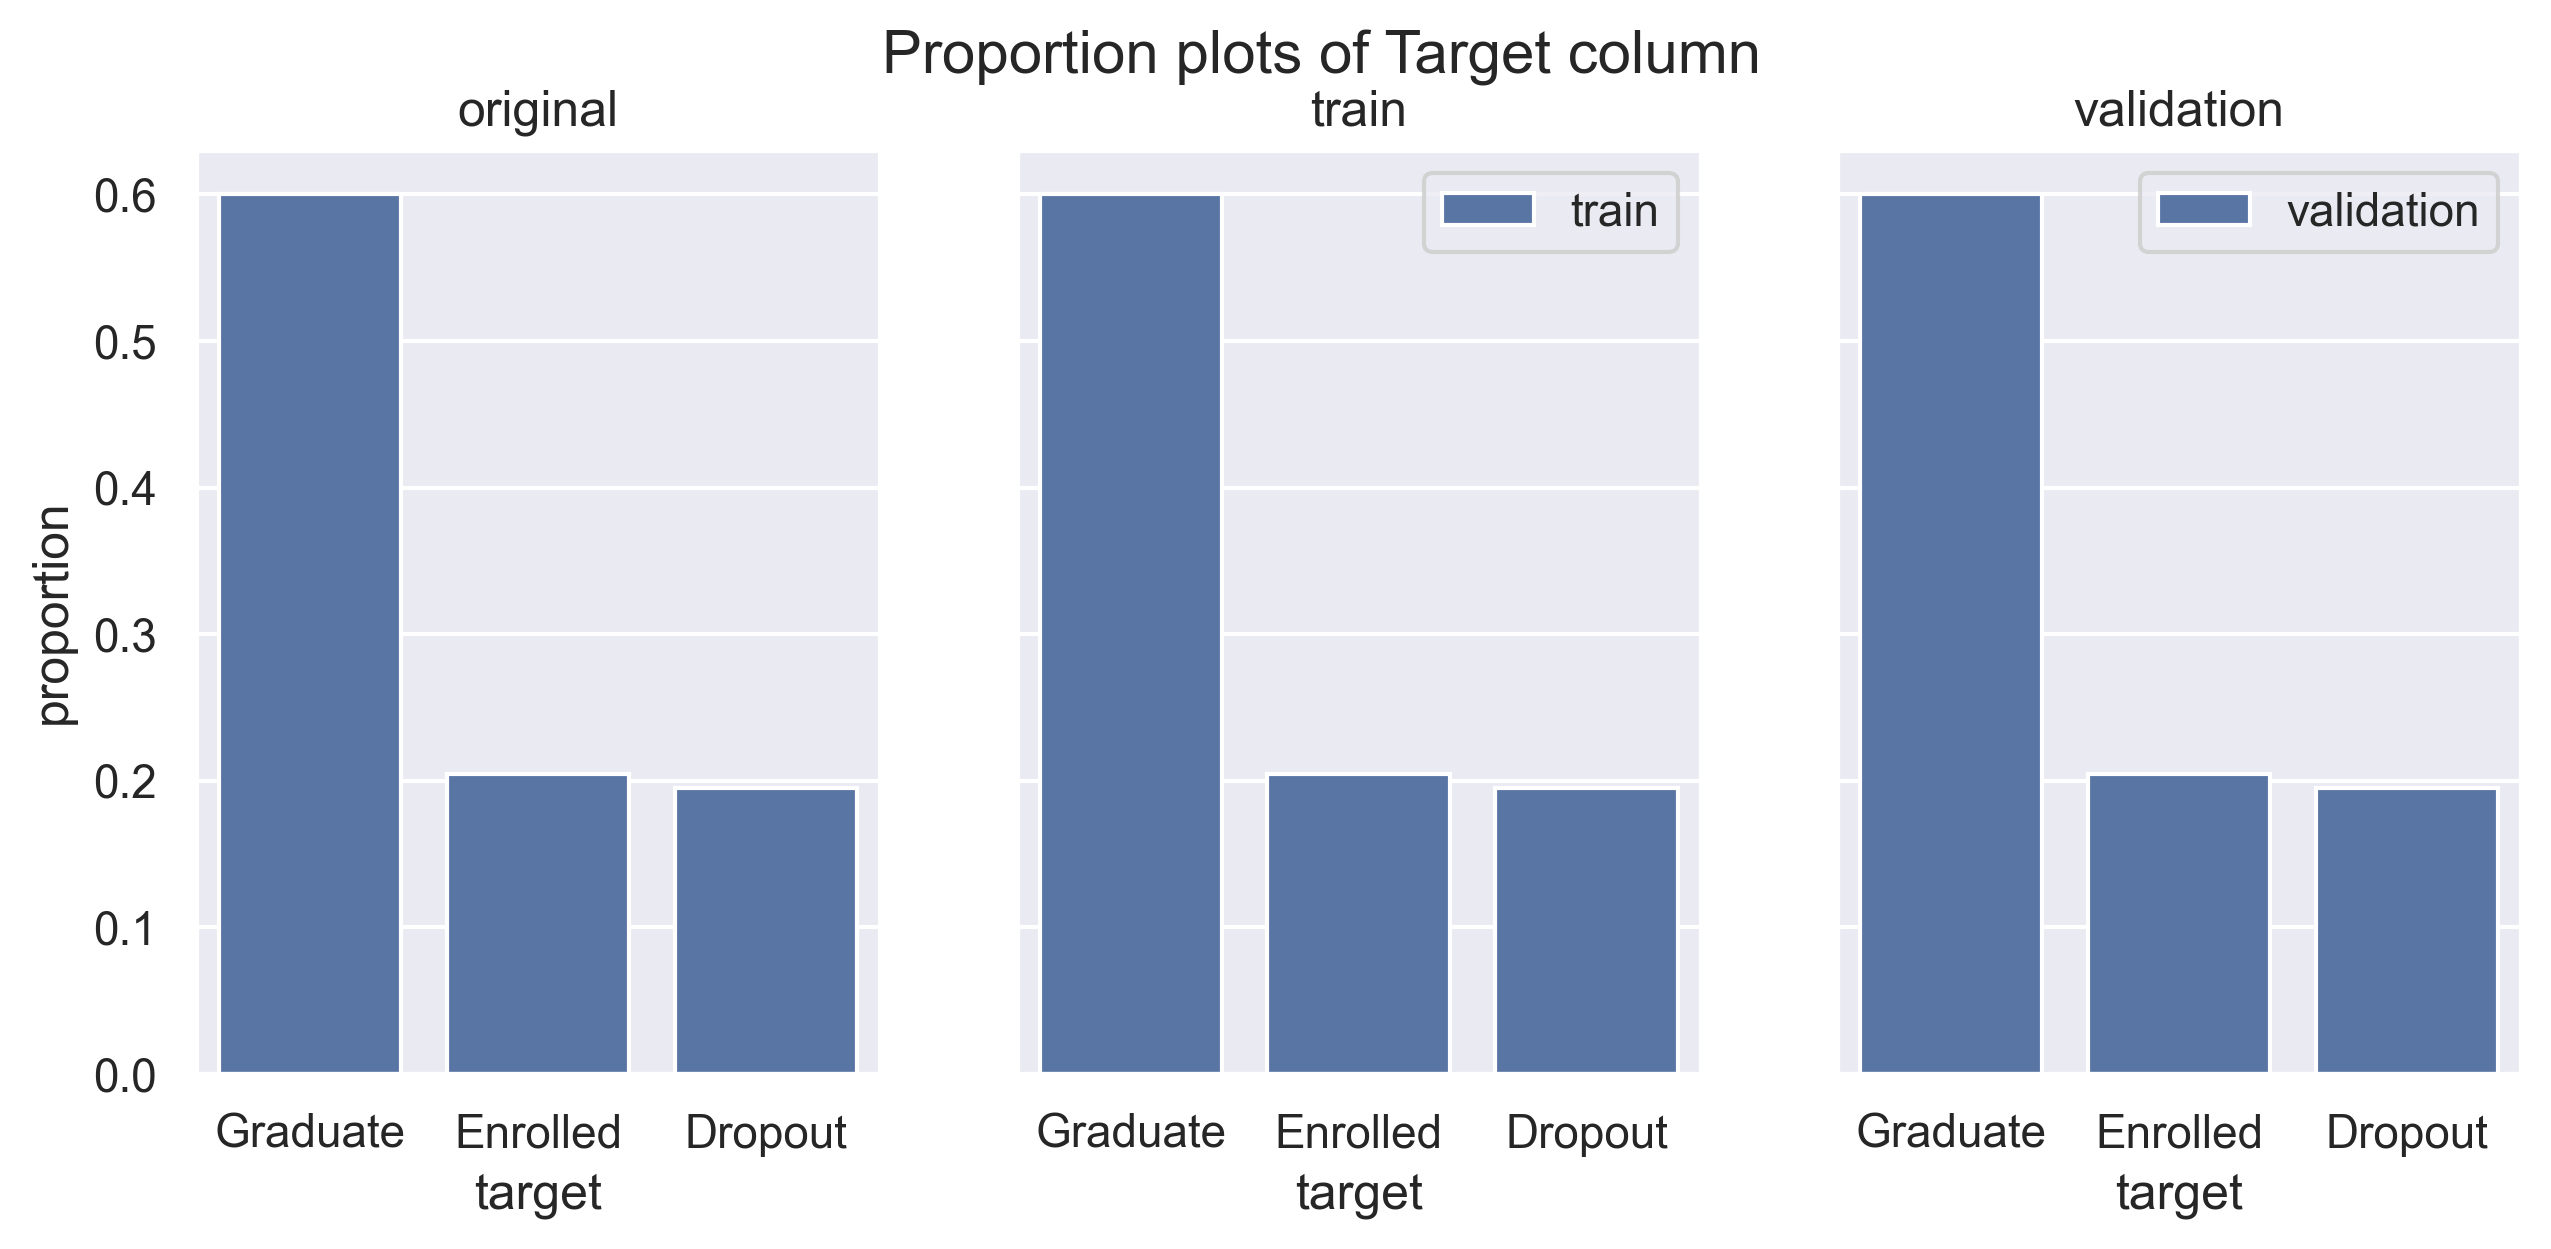

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
orig_label = data[target_column].value_counts(normalize = True).reset_index()
tr_label = training_data[target_column].value_counts(normalize = True).reset_index()
val_label = validation_data[target_column].value_counts(normalize = True).reset_index()
sns.barplot(data = orig_label, x = "target", y = "proportion", ax = ax[0])
ax[0].set_title("original")
sns.barplot(data = tr_label, x = "target", y = "proportion",  ax = ax[1], label = "train")
ax[1].set_title("train")
sns.barplot(data = val_label, x = "target", y = "proportion", ax = ax[2], label = "validation")
ax[2].set_title("validation")
plt.suptitle("Proportion plots of Target column")
plt.show()

##### Preprocess Categorical Columns

In [ ]:
wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)
                    
wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    wrap_category_columns(validation_data,cat_cols)     

print(f"Data Shape: {data.shape}\n Preprocessed Training Shape: {wrapped_train_data.shape}\n Preprocessed Validation Shape: {wrapped_val_data.shape}")   

Data Shape: (3554, 21)
 Preprocessed Training Shape: (1777, 11)
 Preprocessed Validation Shape: (1777, 11)


##### Bins Hyperparameter

In [ ]:

#bins = [100] * len(wrapped_train_data.columns)
stretch_type_gaussian  = (["Gaussian"] * (len(wrapped_train_data.columns)-1)) + ["Uniform"]
stretch_nogan_orig  = [-1] * len(wrapped_train_data.columns)

# bins = [41, 251, 11, 31, 31, 11, 31, 21, 61, 41, 131, 361, 81, 11, 1, 421, 321, 451, 351, 11, 40]


##### Train NoGAN Model

In [ ]:
nogan = NoGANSynth(wrapped_train_data,random_seed=seed)
nogan.fit()
print("******NoGAN Original******")
wrapped_nogan_orig_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch = stretch_nogan_orig
                                                         )

print()
print("******NoGAN Gaussian******")
wrapped_nogan_gauss_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch_type= stretch_type_gaussian
                                                         )
print()
print("******NoGAN Uniform******")
wrapped_nogan_uniform_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True
                                                         )
print()
print(wrapped_nogan_orig_synth_data.shape, wrapped_nogan_gauss_synth_data.shape, wrapped_nogan_uniform_synth_data.shape)


******NoGAN Original******
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

******NoGAN Gaussian******
List `stretch_type`: ['Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

******NoGAN Uniform******
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

(1777, 11) (1777, 11) (1777, 11)


##### Evaluate using ECDF & KS Stat

In [ ]:
# Calculate ECDFs & KS Stats 

# For NoGAN
_, ecdf_val1, ecdf_nogan_orig_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_orig_synth_data, 
                              n_nodes = 1000,
                              verbose = False,
                              random_seed=seed)

# For CTGAN
_, ecdf_val2, ecdf_nogan_gauss_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_gauss_synth_data, 
                              n_nodes = 1000,
                              verbose = False,
                              random_seed=seed)            

_, ecdf_val3, ecdf_nogan_uniform_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_uniform_synth_data, 
                              n_nodes = 10000,
                              verbose = False,
                              random_seed=seed)
            
_, ecdf_val4, ecdf_train = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_train_data, 
                              n_nodes = 1000,
                              verbose = False,
                              random_seed=seed)            
            
ks_stat_nogan_orig = ks_statistic(ecdf_val1, ecdf_nogan_orig_synth)
ks_stat_nogan_gauss = ks_statistic(ecdf_val2, ecdf_nogan_gauss_synth)
ks_stat_nogan_uniform = ks_statistic(ecdf_val3, ecdf_nogan_uniform_synth)
ks_stat_train = ks_statistic(ecdf_val4, ecdf_train)

print(f"KS Stat NoGAN Original(Synth vs Validation): {ks_stat_nogan_orig:.5f}")
print(f"KS Stat NoGAN Gauss (Synth vs Validation): {ks_stat_nogan_gauss:.5f}")
print(f"KS Stat NoGAN Uniform (Synth vs Validation): {ks_stat_nogan_uniform:.5f}")
print(f"Base KS Stat (Synth vs Train): {ks_stat_train:.5f}")

KS Stat NoGAN Original(Synth vs Validation): 0.08104
KS Stat NoGAN Gauss (Synth vs Validation): 0.04446
KS Stat NoGAN Uniform (Synth vs Validation): 0.04277
Base KS Stat (Synth vs Train): 0.04052


In [ ]:
wrapped_nogan_orig_synth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   curricular_units_2nd_sem_approved     1777 non-null   int32  
 1   curricular_units_2nd_sem_grade        1777 non-null   float64
 2   curricular_units_1st_sem_approved     1777 non-null   int32  
 3   curricular_units_1st_sem_grade        1777 non-null   float64
 4   admission_grade                       1777 non-null   float64
 5   curricular_units_2nd_sem_evaluations  1777 non-null   int32  
 6   age_at_enrollment                     1777 non-null   int32  
 7   previous_qualification_grade          1777 non-null   float64
 8   curricular_units_1st_sem_evaluations  1777 non-null   int32  
 9   curricular_units_2nd_sem_enrolled     1777 non-null   int32  
 10  cat_label                             1777 non-null   int32  
dtypes: float64(4), in

##### Expand Categorical Columns in Synth Data

In [ ]:
nogan_orig_synth_data = unwrap_category_columns(data=wrapped_nogan_orig_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)

nogan_orig_synth_data = nogan_orig_synth_data[features]

nogan_gauss_synth_data = unwrap_category_columns(data=wrapped_nogan_gauss_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)

nogan_gauss_synth_data = nogan_gauss_synth_data[features]

nogan_uniform_synth_data = unwrap_category_columns(data=wrapped_nogan_uniform_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)

nogan_uniform_synth_data = nogan_uniform_synth_data[features]

print(nogan_orig_synth_data.shape, nogan_gauss_synth_data.shape, nogan_uniform_synth_data.shape)

(1777, 21) (1777, 21) (1777, 21)


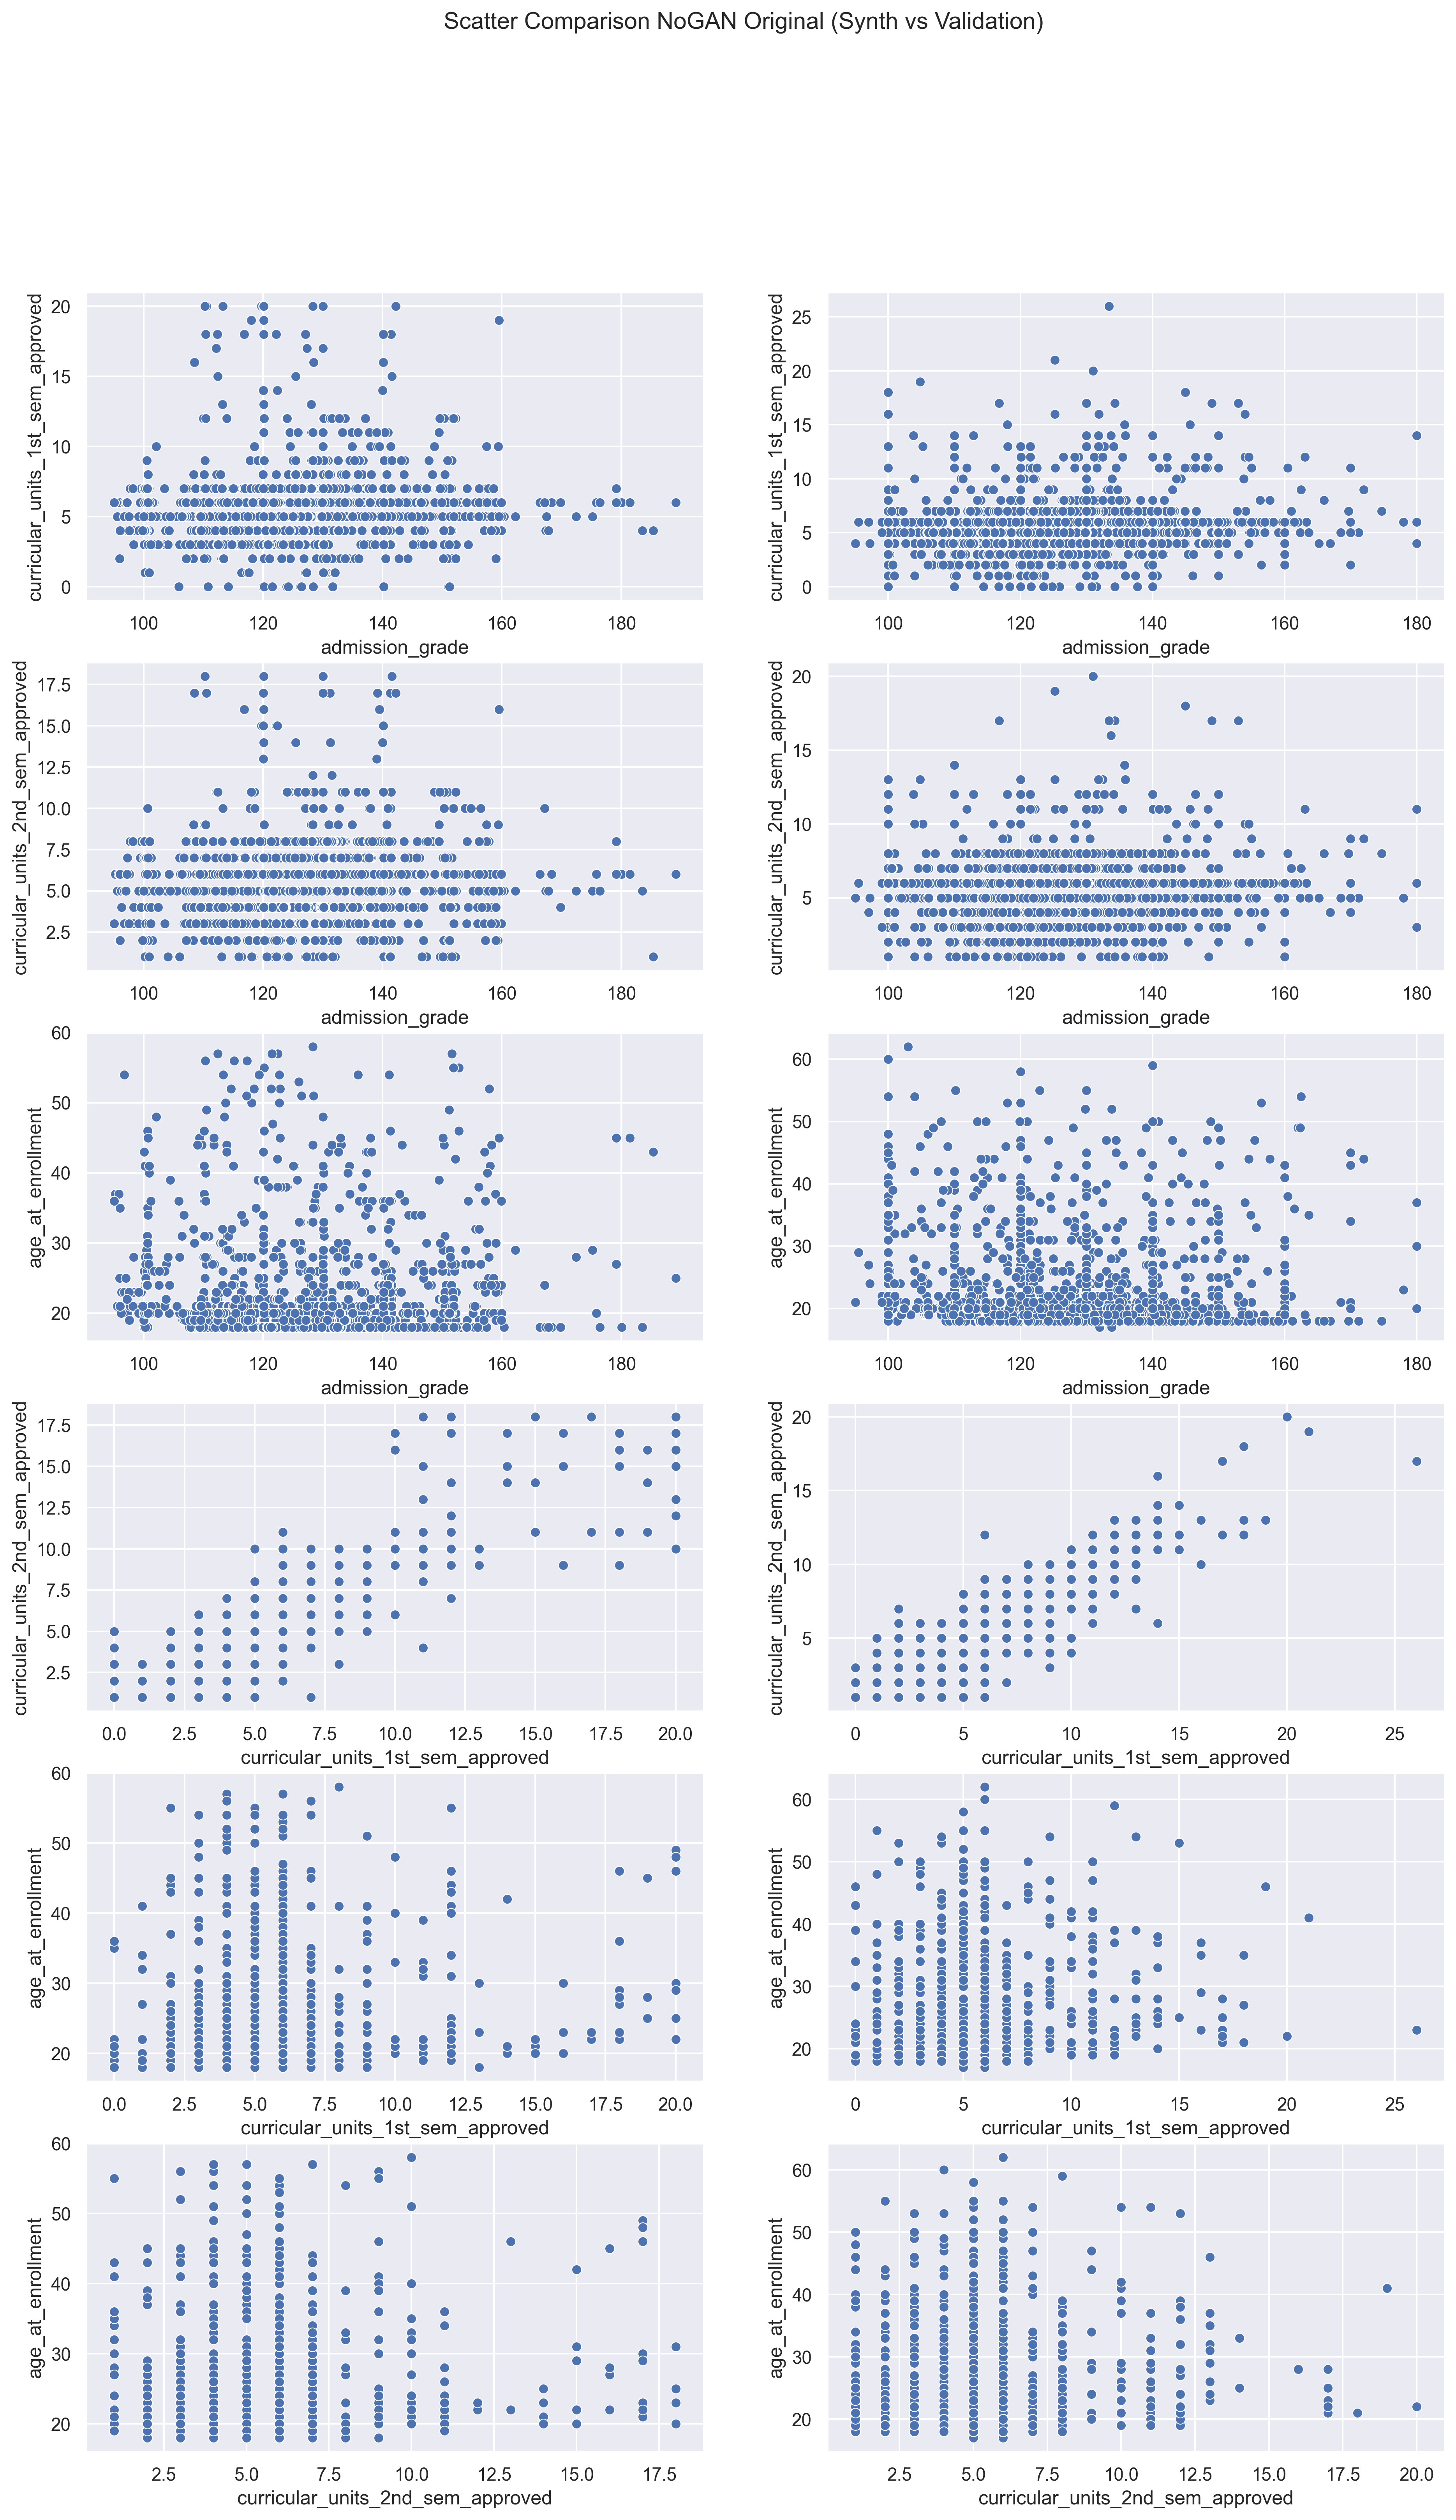

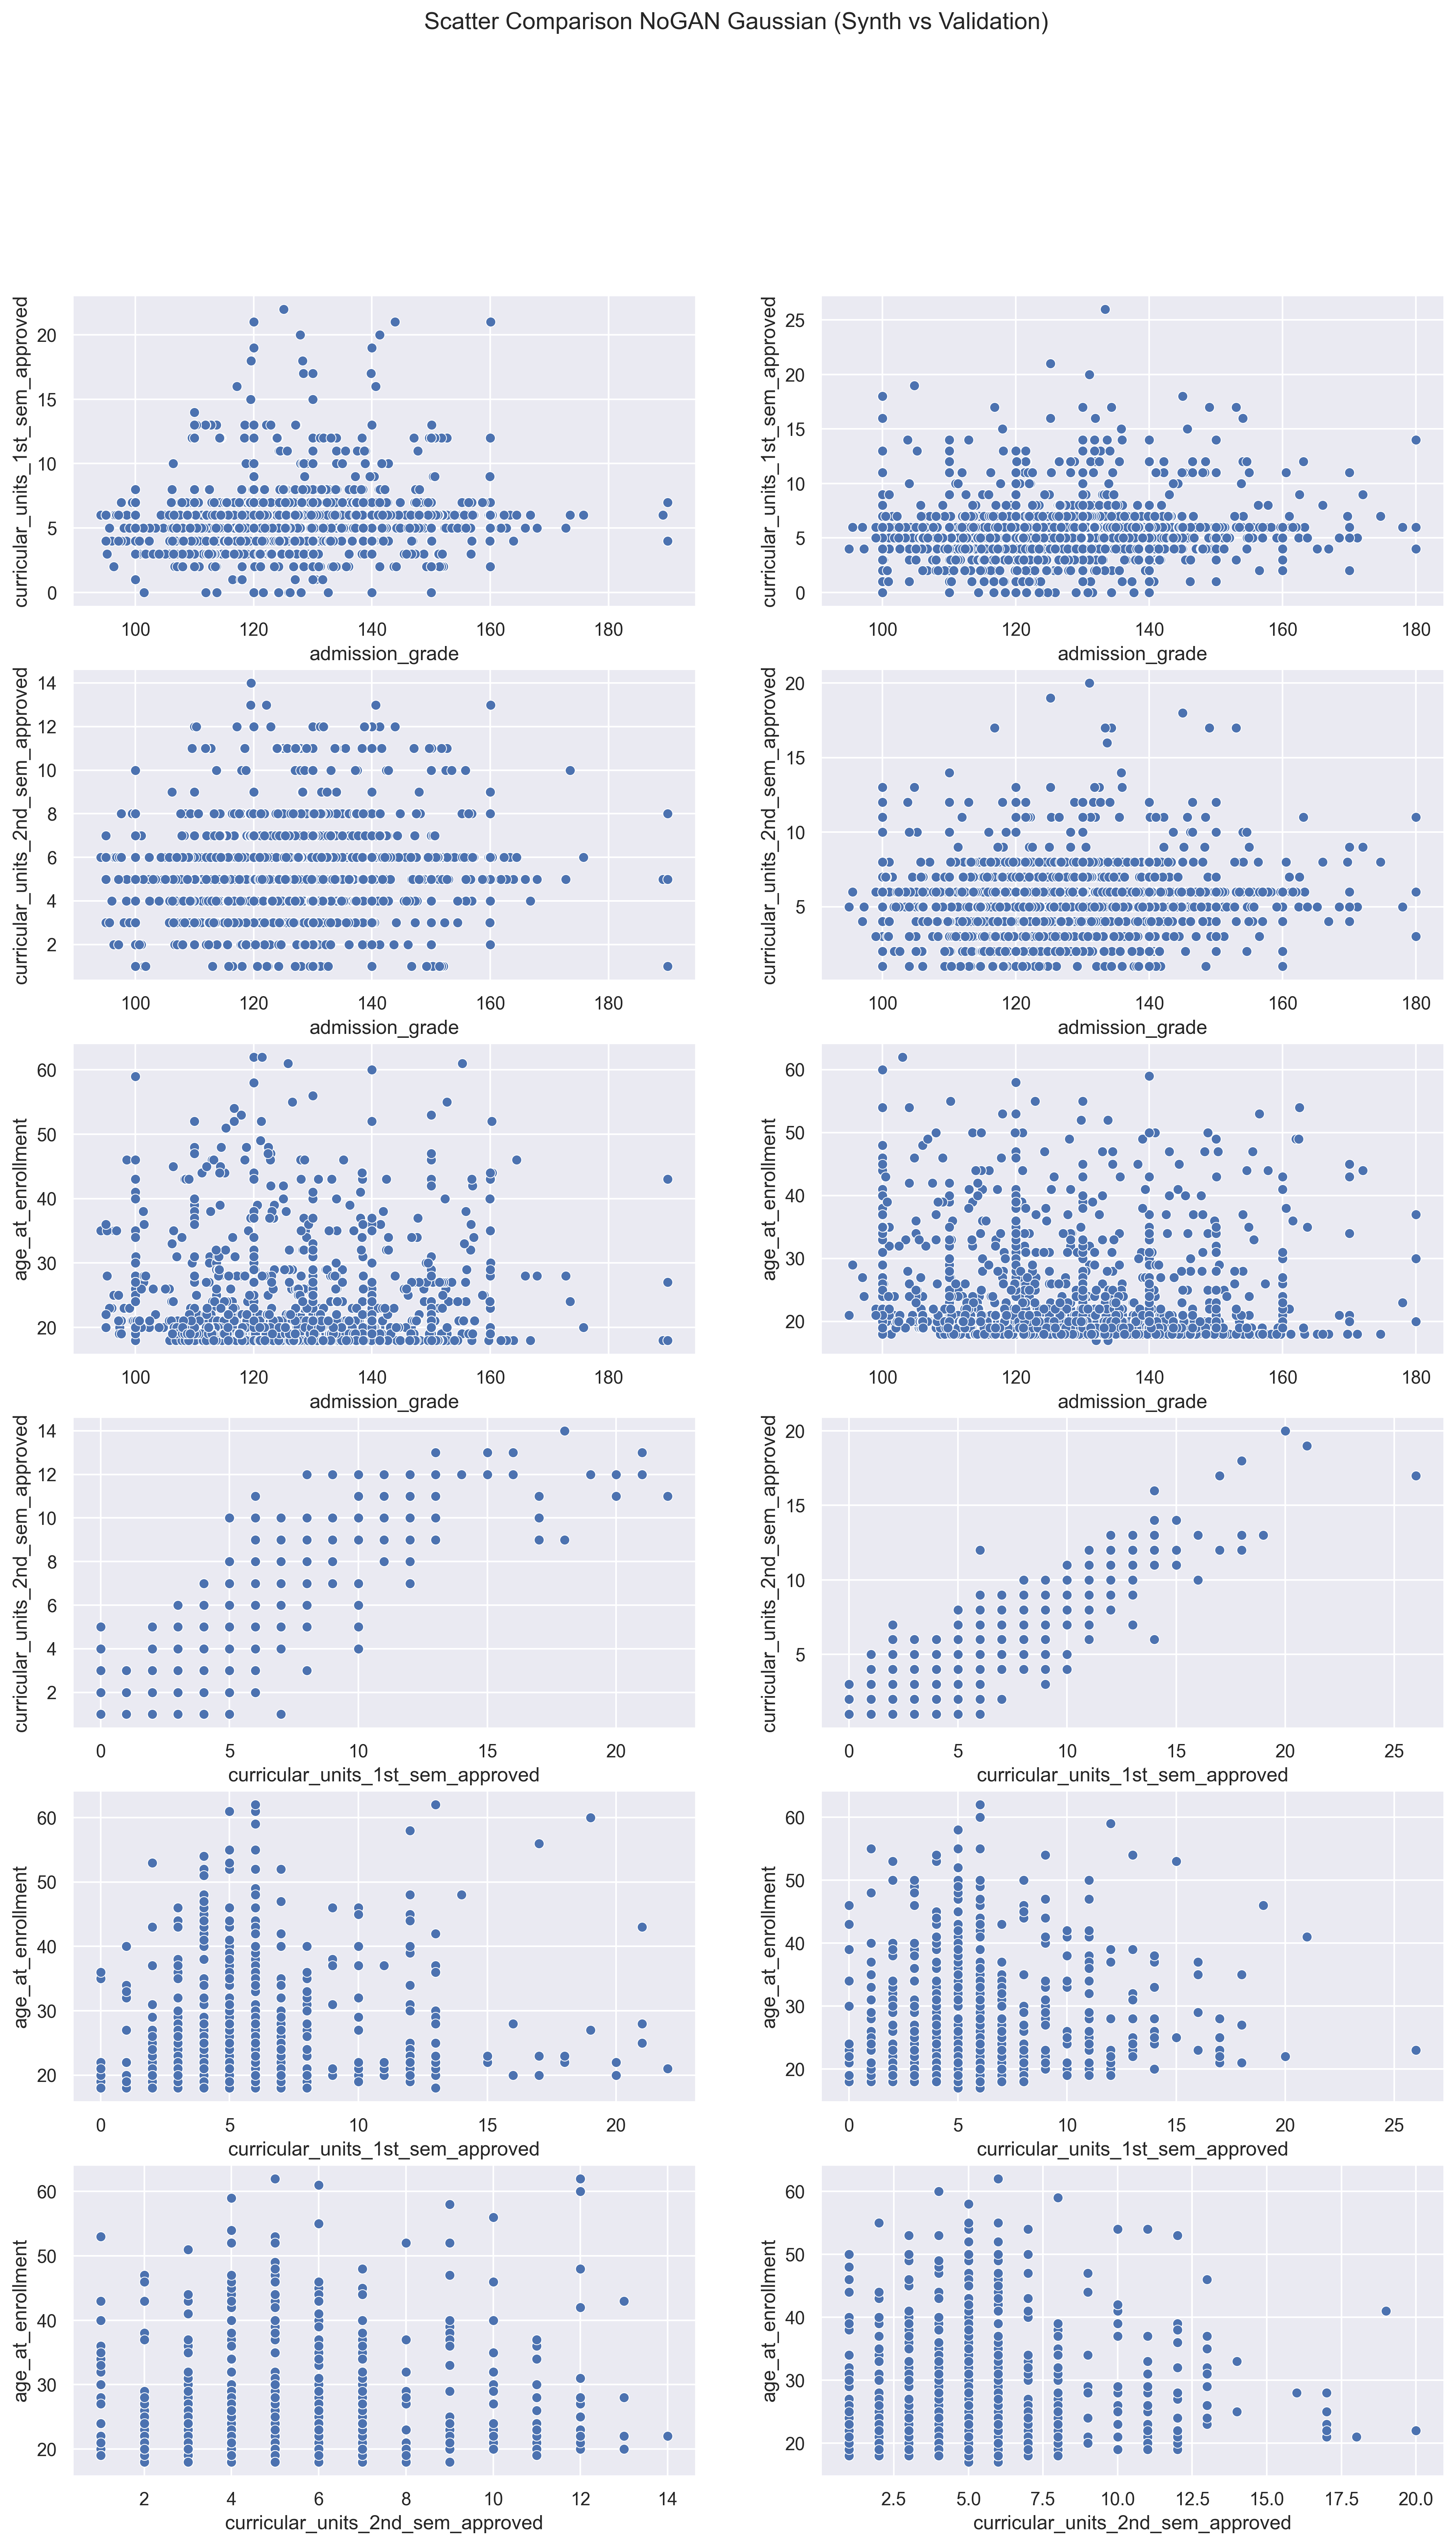

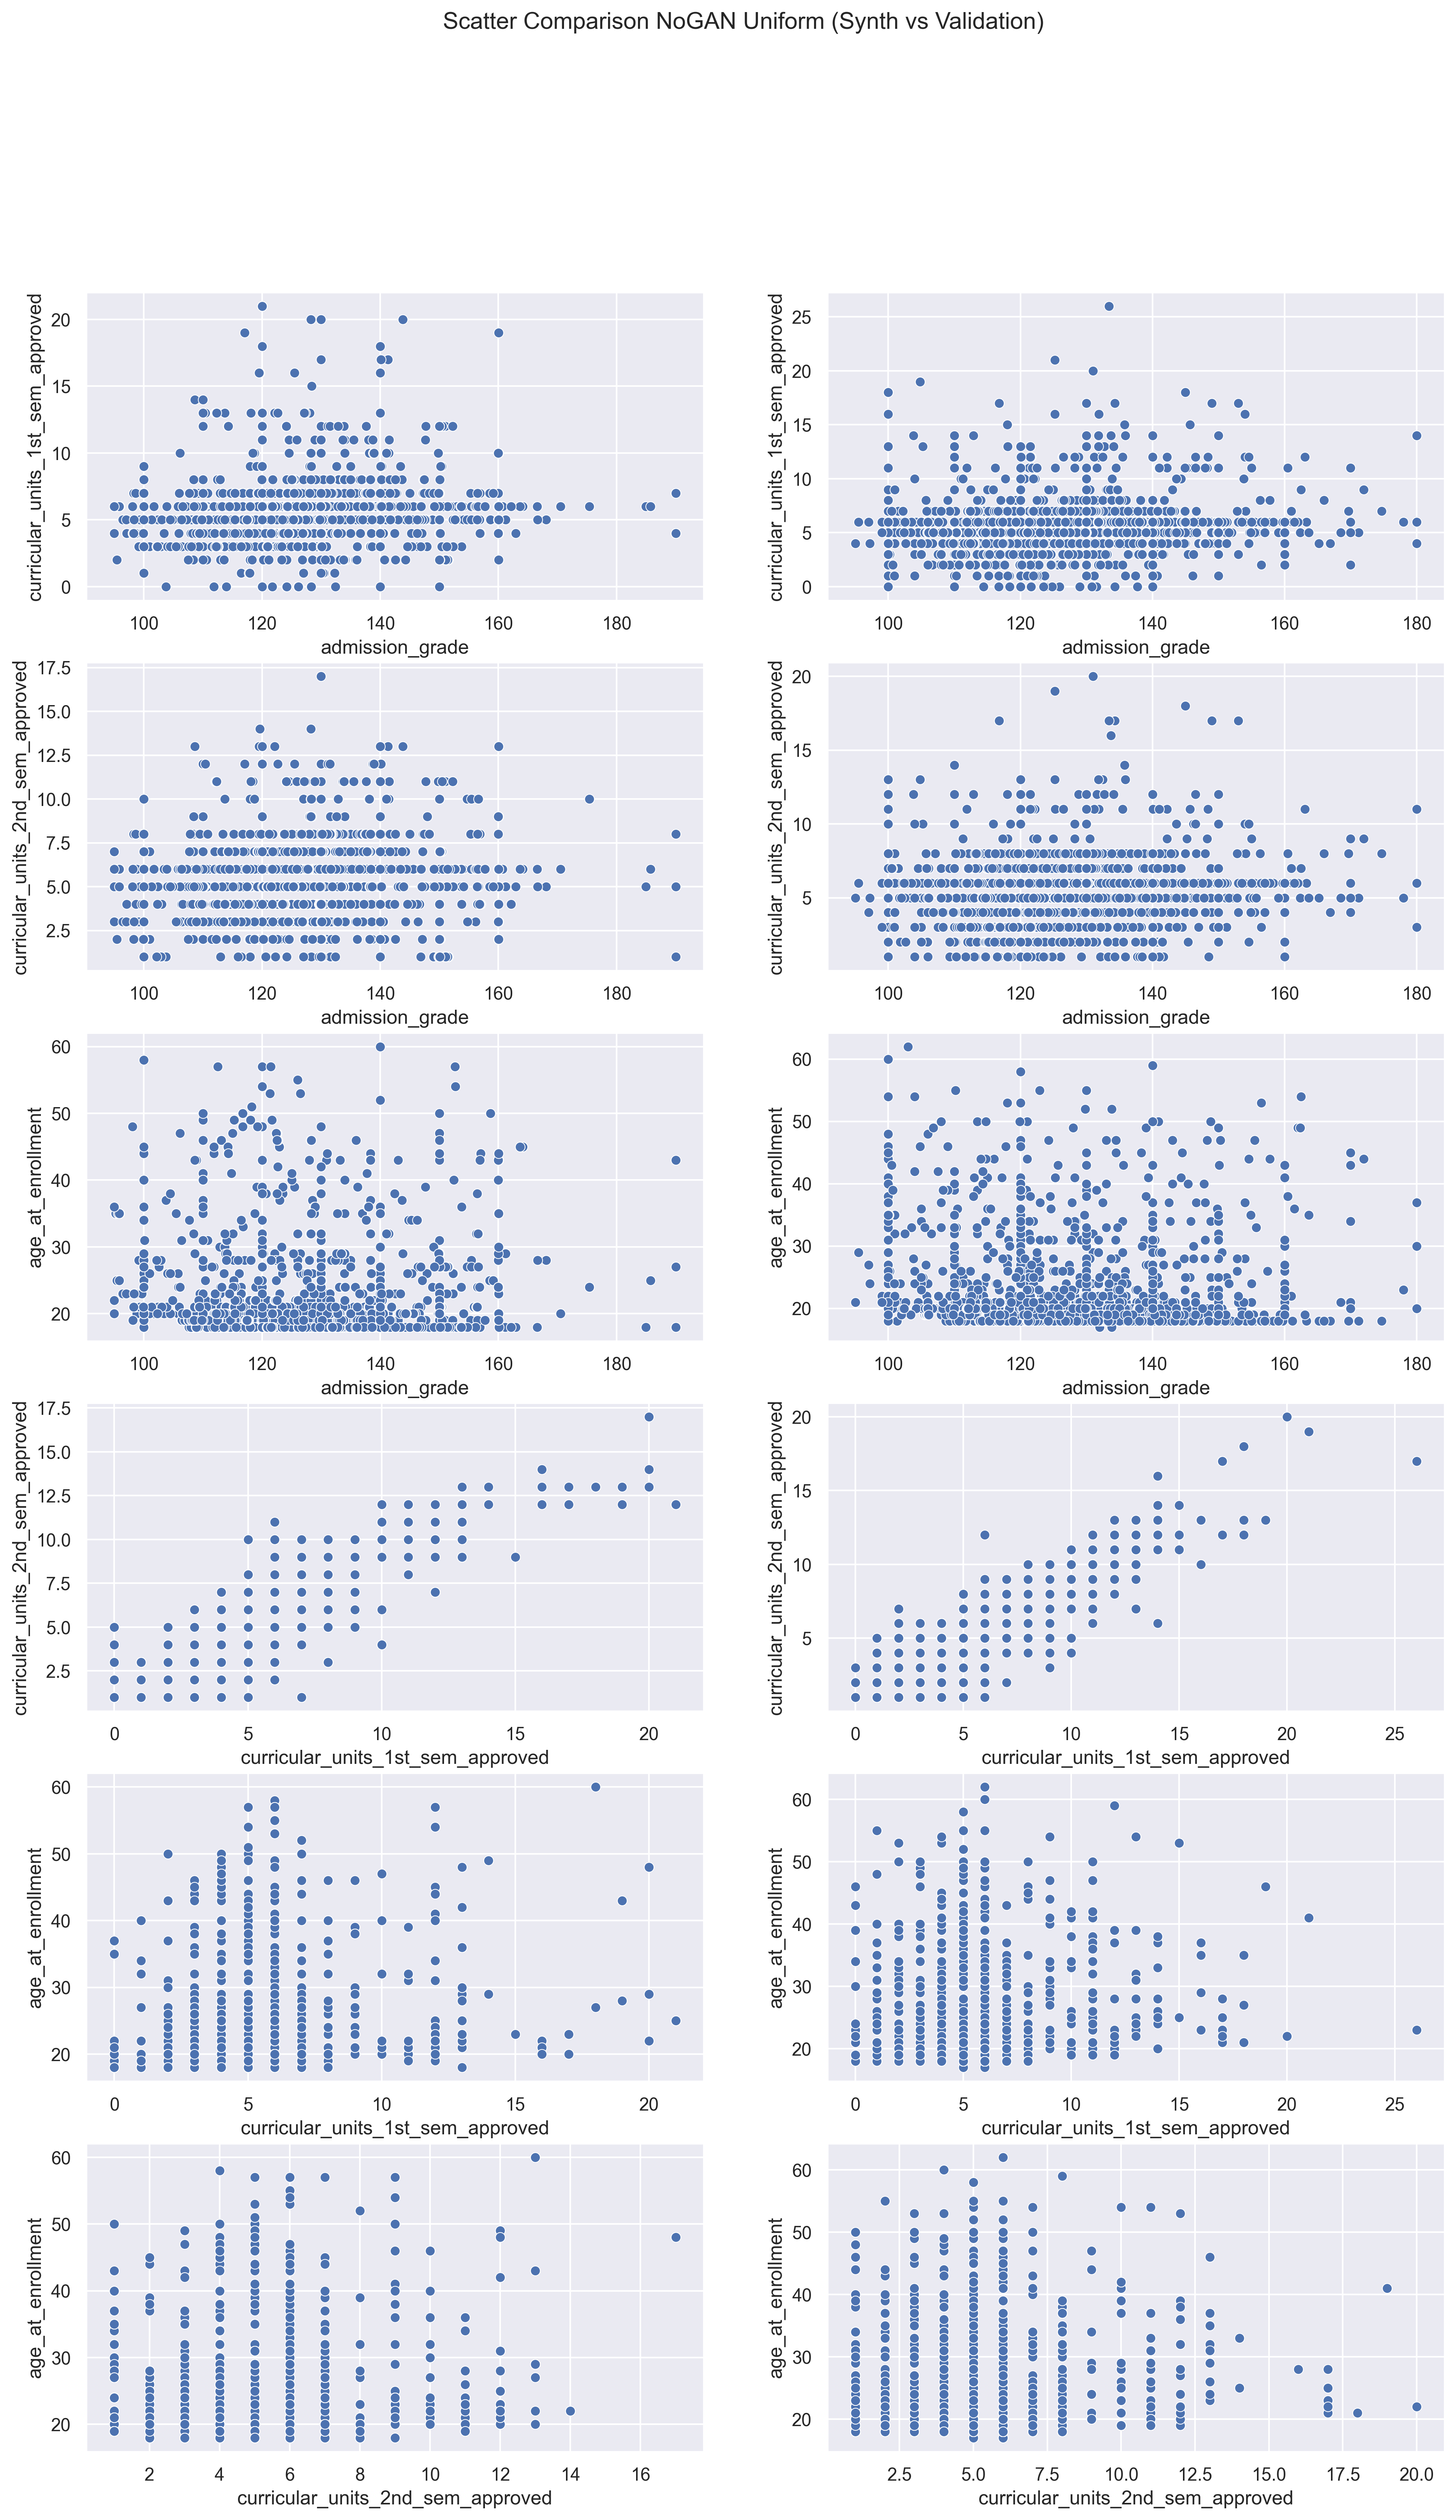

In [ ]:
plot_num_cols = \
        [num_cols[i] for i in np.random.choice(len(num_cols), size = 4, replace = False)]
dfs_orig = nogan_orig_synth_data
dfs_gauss = nogan_gauss_synth_data
dfs_uniform = nogan_uniform_synth_data
dfv = validation_data

utils.plot_scatter_comparison(dfs_orig, dfv, 
                              features = plot_num_cols,
                              title = "Scatter Comparison NoGAN Original (Synth vs Validation)"
                              )

utils.plot_scatter_comparison(dfs_gauss, dfv, 
                              features = plot_num_cols,
                              title = "Scatter Comparison NoGAN Gaussian (Synth vs Validation)"
                              )

utils.plot_scatter_comparison(dfs_uniform, dfv, 
                              features = plot_num_cols,
                              title = "Scatter Comparison NoGAN Uniform (Synth vs Validation)"
                              )


##### Evaluation using Table Evaluator Package

In [ ]:

from table_evaluator import load_data, TableEvaluator

# Evaluation for NoGAN Orig
table_evaluator_nogan_orig = TableEvaluator(validation_data, nogan_orig_synth_data, 
                                       cat_cols=cat_cols)

result = table_evaluator_nogan_orig.evaluate(target_col='target', return_outputs=True)
nogan_orig_synth_score = result["Overview Results"]["Similarity Score"]["result"]


# Evaluation for NoGAN Gauss
table_evaluator_nogan_gauss = TableEvaluator(validation_data, nogan_gauss_synth_data, 
                                       cat_cols=cat_cols)

result = table_evaluator_nogan_gauss.evaluate(target_col='target', return_outputs=True)
nogan_gauss_synth_score = result["Overview Results"]["Similarity Score"]["result"]


# Evaluation for NoGAN Uniform
table_evaluator_nogan_uniform = TableEvaluator(validation_data, nogan_uniform_synth_data, 
                                       cat_cols=cat_cols)

result = table_evaluator_nogan_uniform.evaluate(target_col='target', return_outputs=True)
nogan_uniform_synth_score = result["Overview Results"]["Similarity Score"]["result"]

##### Results

In [ ]:
comp_results = {}
comp_results["Original"] = {"Similarity Score": nogan_orig_synth_score,
                            "KS Statistic": ks_stat_nogan_orig,
                            "Base KS Statistic": ks_stat_train}

comp_results["Gaussian"] = {"Similarity Score": nogan_gauss_synth_score,
                            "KS Statistic": ks_stat_nogan_gauss,
                            "Base KS Statistic": ks_stat_train}

comp_results["Uniform"] = {"Similarity Score": nogan_uniform_synth_score,
                            "KS Statistic": ks_stat_nogan_uniform,
                            "Base KS Statistic": ks_stat_train}


final_results_df = pd.DataFrame.from_dict(comp_results, orient="index").reset_index().rename(columns = {"index": "NoGAN Version"})
final_results_df

NoGAN Version  Similarity Score  KS Statistic  Base KS Statistic
0      Original            0.9180        0.0810             0.0405
1      Gaussian            0.9294        0.0445             0.0405
2       Uniform            0.9299        0.0428             0.0405

##### Observations
* Performance for `NoGAN models with default bins` starting with best to worst:
    - Uniform -> Gaussian -> Original
* Data Quality of Synth compared to Validation (as per Scatter Plots) best to worst:
    - Uniform -> Gaussian -> Original